# Genomic Grammar Analysis

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Maximum, Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [2]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline
from sklearn import model_selection
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
if not os.path.isdir('/home/jtao/analysis/genomic_grammar_analysis/'):
    os.mkdir('/home/jtao/analysis/genomic_grammar_analysis')
os.chdir('/home/jtao/analysis/genomic_grammar_analysis')

## Functions

In [4]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''

    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0.25,0.25,0.25,0.25]}

    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array)
        sequence_array_list.append(seq_array)
    sequence_array_list = np.array(sequence_array_list)
    return sequence_array_list

In [ ]:
sequences = []
positive_seqRecords = list(SeqIO.parse('./c57bl6_atf3_veh_idr_peaks.fasta', 'fasta'))
negative_seqRecords = list(SeqIO.parse('./background.fasta', 'fasta'))

fasta_seq = [str(x.seq)[:200] for x in positive_seqRecords] + [str(x.seq)[:200] for x in negative_seqRecords]

In [ ]:

labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)

In [ ]:
sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, labels, test_size=0.2)

In [ ]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Define Model

In [39]:
def count_num_params(seq_size,
                     num_motifs, 
                     motif_size,
                     adjacent_bp_pool_size,
                     attention_dim,
                     attention_hops,
                     num_dense_neurons
                    ):
    total_params = 0
    
    # convolution layer
    convolution_params = num_motifs * motif_size * 4
    total_params += convolution_params
    print('Convolution Params:', convolution_params)
    
    # lstm layer
    # account for pooling
    lstm_input_size = num_motifs
    # account for reverse complement sequence
    lstm_input_size = lstm_input_size * 2
    
    num_lstm_neurons = seq_size/ adjacent_bp_pool_size
    
    lstm_params = lstm_input_size * 4 * num_lstm_neurons
    # account for bidrectional lstm
    lstm_params = lstm_params * 2
    
    total_params += lstm_params
    print('LSTM Params:', lstm_params)
    
    # attention later
    attention_params = attention_dim * (seq_size/adjacent_bp_pool_size*2) 
    # account for hops of attention
    attention_params += attention_dim * attention_hops
    
    total_params += attention_params
    print('Attention Params:', attention_params)
    
    # dense layer
    dense_params = lstm_input_size * num_dense_neurons
    total_params += dense_params
    print('Dense Params:', dense_params)
    
    return total_params

In [46]:
seq_size = 150
num_classes = 2
num_motifs = 20
motif_size = 20
attention_dim = 100 # from A Structured Self-attentive Sentence Embedding
attention_hops = 1 # from A Structured Self-attentive Sentence Embedding
adjacent_bp_pool_size = 2
num_dense_neurons = 2

count_num_params(seq_size,
    num_motifs, 
    motif_size,
    adjacent_bp_pool_size,
    attention_dim,
    attention_hops,
    num_dense_neurons
    )

Convolution Params: 1600
LSTM Params: 24000.0
Attention Params: 15100.0
Dense Params: 80


40780.0

In [ ]:
num_classes = 2
input_fwd = Input(shape=(200,4), name='input_fwd')

shared_motif_convolution = Conv1D(filters=16, 
     kernel_size=24,
     activation='relu',
     input_shape=(200,4))

motif_scores_fwd = shared_motif_convolution(input_fwd)

max_seq_scores = MaxPooling1D(pool_size=176)(motif_scores_fwd)

dense_out = Dense(32, activation='relu')(max_seq_scores)

drop_out = Dropout(0.25)(dense_out)

flattened = Flatten()(drop_out)

predictions = Dense(num_classes, activation = 'softmax')(flattened)

model = Model(inputs=input_fwd, outputs=predictions)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Visualize Model

In [4]:
from keras.layers import Bidirectional

from keras.layers import LSTM

from keras.layers import Activation

In [7]:
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True),
                        input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [8]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

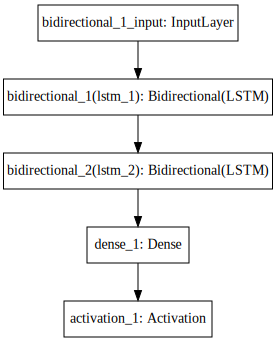

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))